In [ ]:
from google.colab import files
uploaded = files.upload()


Saving SP500.csv to SP500.csv


In [ ]:
!pip install fredapi


#**1.Create the FRED object**

In [ ]:
from fredapi import Fred

fred = Fred(api_key='6dcfeeccf9de4753c4dfeb90bca55039')


#**2.Search for economic data**

In [ ]:
sp_search = fred.search('S&P', order_by='popularity')

In [ ]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2025-04-18,2025-04-18,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2025-04-16,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-04-17 09:09:14-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2025-04-18,2025-04-18,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2025-01-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2025-03-25 08:12:25-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2025-04-18,2025-04-18,S&P 500,2015-04-20,2025-04-17,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2025-04-17 19:11:56-05:00,83,The observations for the S&P 500 represent the...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2025-04-18,2025-04-18,ICE BofA US High Yield Index Effective Yield,1996-12-31,2025-04-16,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-04-17 09:09:17-05:00,82,This data represents the effective yield of th...
BAMLC0A0CM,BAMLC0A0CM,2025-04-18,2025-04-18,ICE BofA US Corporate Index Option-Adjusted Sp...,1996-12-31,2025-04-16,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2025-04-17 09:15:02-05:00,78,The ICE BofA Option-Adjusted Spreads (OASs) ar...


#**3. Pull Raw Data & Plot**

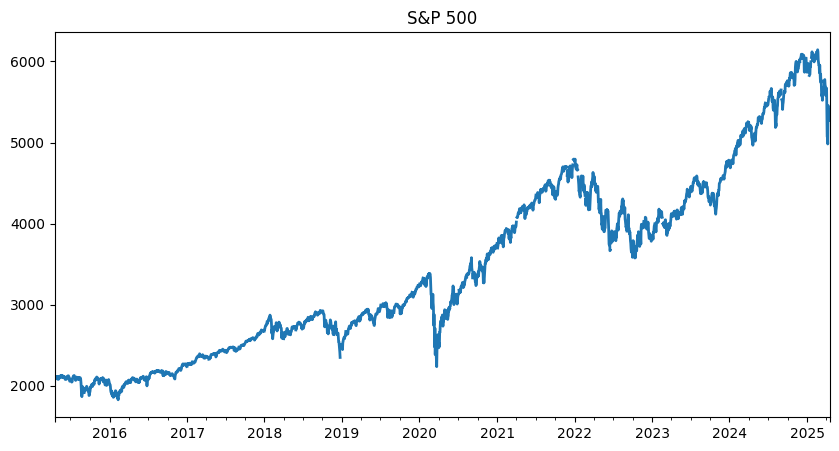

In [ ]:
import matplotlib.pyplot as plt  # Make sure this is imported

sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()


#**4. Pull and Join Multiple Data Series**

In [ ]:
import pandas as pd
from fredapi import Fred
import plotly.express as px

# Step 1: Connect to FRED
fred = Fred(api_key='6dcfeeccf9de4753c4dfeb90bca55039')  # Replace with your actual API key


# Step 2: Search for state-level unemployment rate series (fixed filter syntax)
unemp_df = fred.search('Unemployment Rate in', filter=('frequency', 'Monthly'))


# Filter to get only state-level, seasonally adjusted series
state_unemp_df = unemp_df[
    (unemp_df['title'].str.contains('Unemployment Rate in')) &
    (unemp_df['seasonal_adjustment'] == 'Seasonally Adjusted')
]

# Step 3: Fetch time series for all state-level unemployment rates
series_ids = state_unemp_df['id'].tolist()

state_data = {}
for series_id in series_ids:
    state_data[series_id] = fred.get_series(series_id)

# Step 4: Convert to DataFrame
unemp_states = pd.DataFrame(state_data)
unemp_states.index.name = 'Date'
unemp_states = unemp_states.reset_index()

# Step 5: Convert to long format for plotting
unemp_long = unemp_states.melt(id_vars='Date', var_name='SeriesID', value_name='Unemployment Rate')

# Step 6: Map series IDs to full state names using the original title
id_to_title = state_unemp_df.set_index('id')['title'].to_dict()
unemp_long['State'] = unemp_long['SeriesID'].map(lambda x: id_to_title[x].replace('Unemployment Rate in ', ''))

# Step 7: Plot with Plotly
fig = px.line(unemp_long, x='Date', y='Unemployment Rate', color='State',
              title='Monthly Unemployment Rates by State (Seasonally Adjusted)',
              labels={'Unemployment Rate': 'Unemployment Rate (%)'})
fig.update_layout(legend_title_text='State')
fig.show()


#**Pull April 2020 Unemployment Rate Per State**

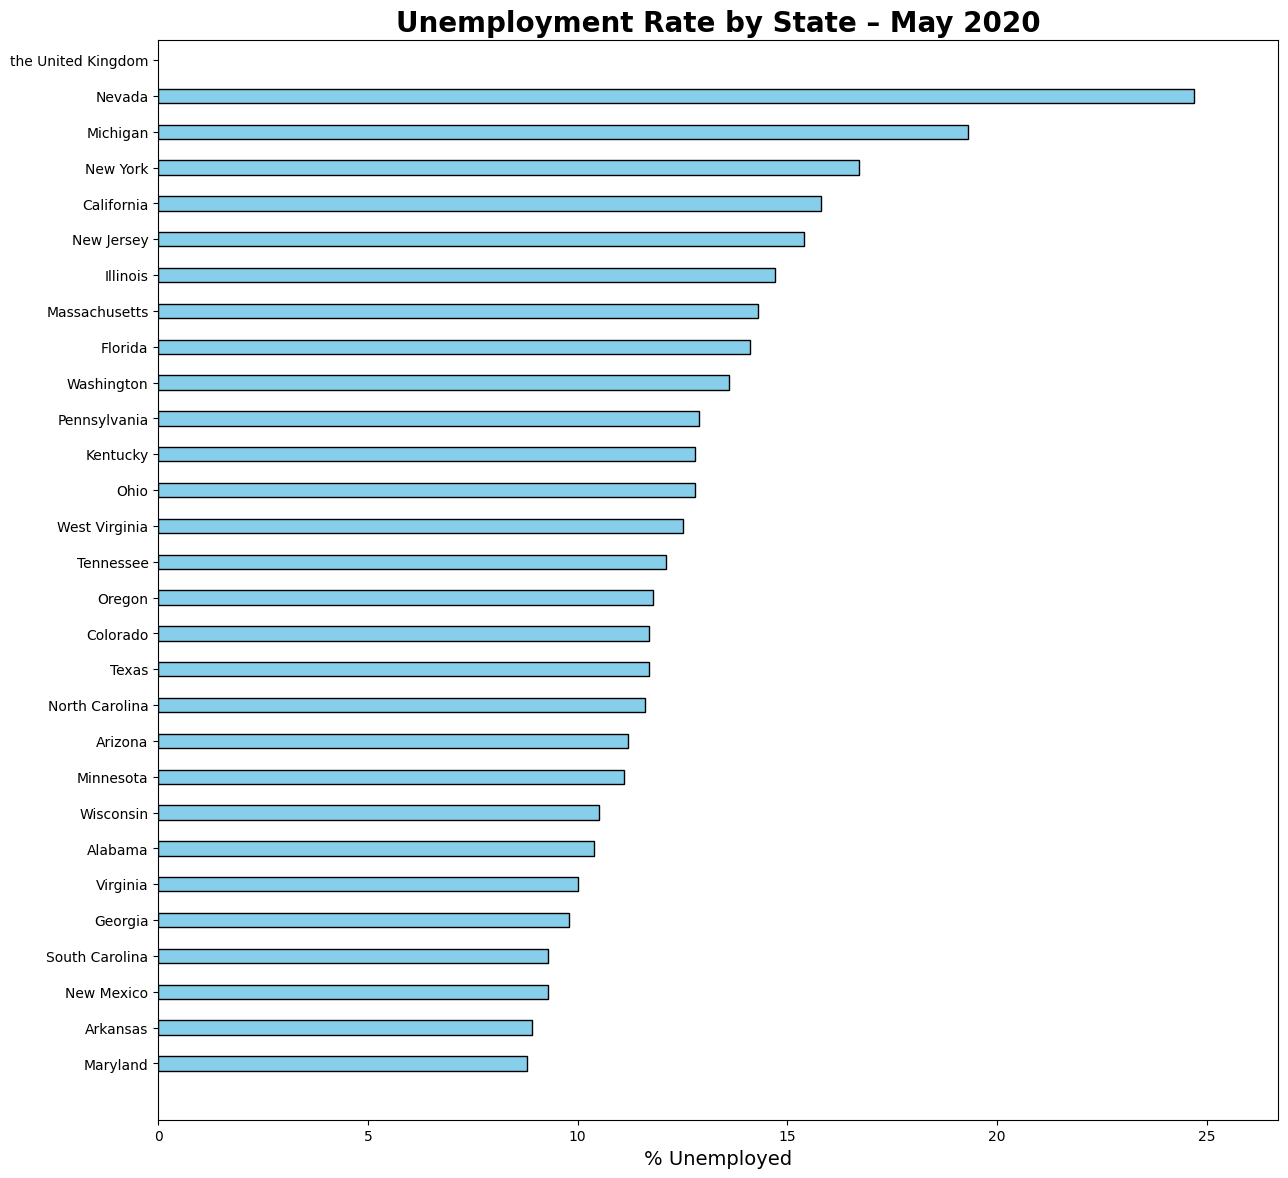

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Extract May 2020 data
row = unemp_states[unemp_states['Date'] == '2020-05-01'].drop(columns='Date').T

# Step 2: Map SeriesID to state names
id_to_title = state_unemp_df.set_index('id')['title'].to_dict()
row.index = row.index.map(lambda x: id_to_title[x].replace('Unemployment Rate in ', ''))

# Step 3: Sort values by unemployment rate
row = row.sort_values(by=row.columns[0])

# Step 4: Create figure with adjusted size for better space management
fig, ax = plt.subplots(figsize=(16, 12))  # Adjusted figure size for tight layout

# Step 5: Plot horizontal bars with minimal width and reduced spacing
bars = ax.barh(row.index, row.iloc[:, 0], color='skyblue', edgecolor='black', height=0.4)  # Reduced bar height

# Step 6: Set axis labels and title
ax.set_xlabel('% Unemployed', fontsize=14)
ax.set_ylabel('')
ax.set_title('Unemployment Rate by State – May 2020', fontsize=20, weight='bold')

# Step 7: Adjust x-axis to ensure space on the right
ax.set_xlim(0, row.iloc[:, 0].max() + 2)

# Step 8: Adjust layout to make sure everything fits with minimal space between bars
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.05)  # Tighter margins

# Step 9: Show the plot
plt.show()











#**Pull Participation Rate**

In [ ]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')


In [ ]:
import time
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

#**Plot Unemployment vs Participation for each state**

In [ ]:
# Fix DC
unemp_states = unemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

In [ ]:
# Make sure the Date column is datetime and set as index
unemp_states['Date'] = pd.to_datetime(unemp_states['Date'], errors='coerce')
unemp_states = unemp_states.set_index('Date')

# Check result
print(unemp_states.index[:5])





DatetimeIndex(['1855-01-01', '1855-02-01', '1855-03-01', '1855-04-01',
               '1855-05-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
print(part_states.head())

            Labor Force Participation Rate  \
Date                                         
1948-01-01                            58.6   
1948-02-01                            58.9   
1948-03-01                            58.5   
1948-04-01                            59.0   
1948-05-01                            58.3   

            Labor Force Participation Rate - 25-54 Yrs.  \
Date                                                      
1948-01-01                                         64.2   
1948-02-01                                         64.6   
1948-03-01                                         64.3   
1948-04-01                                         64.8   
1948-05-01                                         64.3   

            Labor Force Participation Rate - Women  \
Date                                                 
1948-01-01                                    32.0   
1948-02-01                                    32.4   
1948-03-01                                    3

In [ ]:
part_states.index = pd.to_datetime(part_states.index, errors='coerce')
unemp_states.index = pd.to_datetime(unemp_states.index, errors='coerce')



In [ ]:
# Two separate masks based on each DataFrame's own index
mask_unemp = (unemp_states.index >= '2020-01-01') & (unemp_states.index < '2022-01-01')
mask_part = (part_states.index >= '2020-01-01') & (part_states.index < '2022-01-01')




In [ ]:
unemp_states.index = pd.to_datetime(unemp_states.index)
part_states.index = pd.to_datetime(part_states.index)



In [ ]:
# Ensure both dataframes have columns named like "California", "Texas"
# Apply this mapping to unemp_states
unemp_states.columns = [id_to_title[c].replace('Unemployment Rate in ', '') for c in unemp_states.columns]


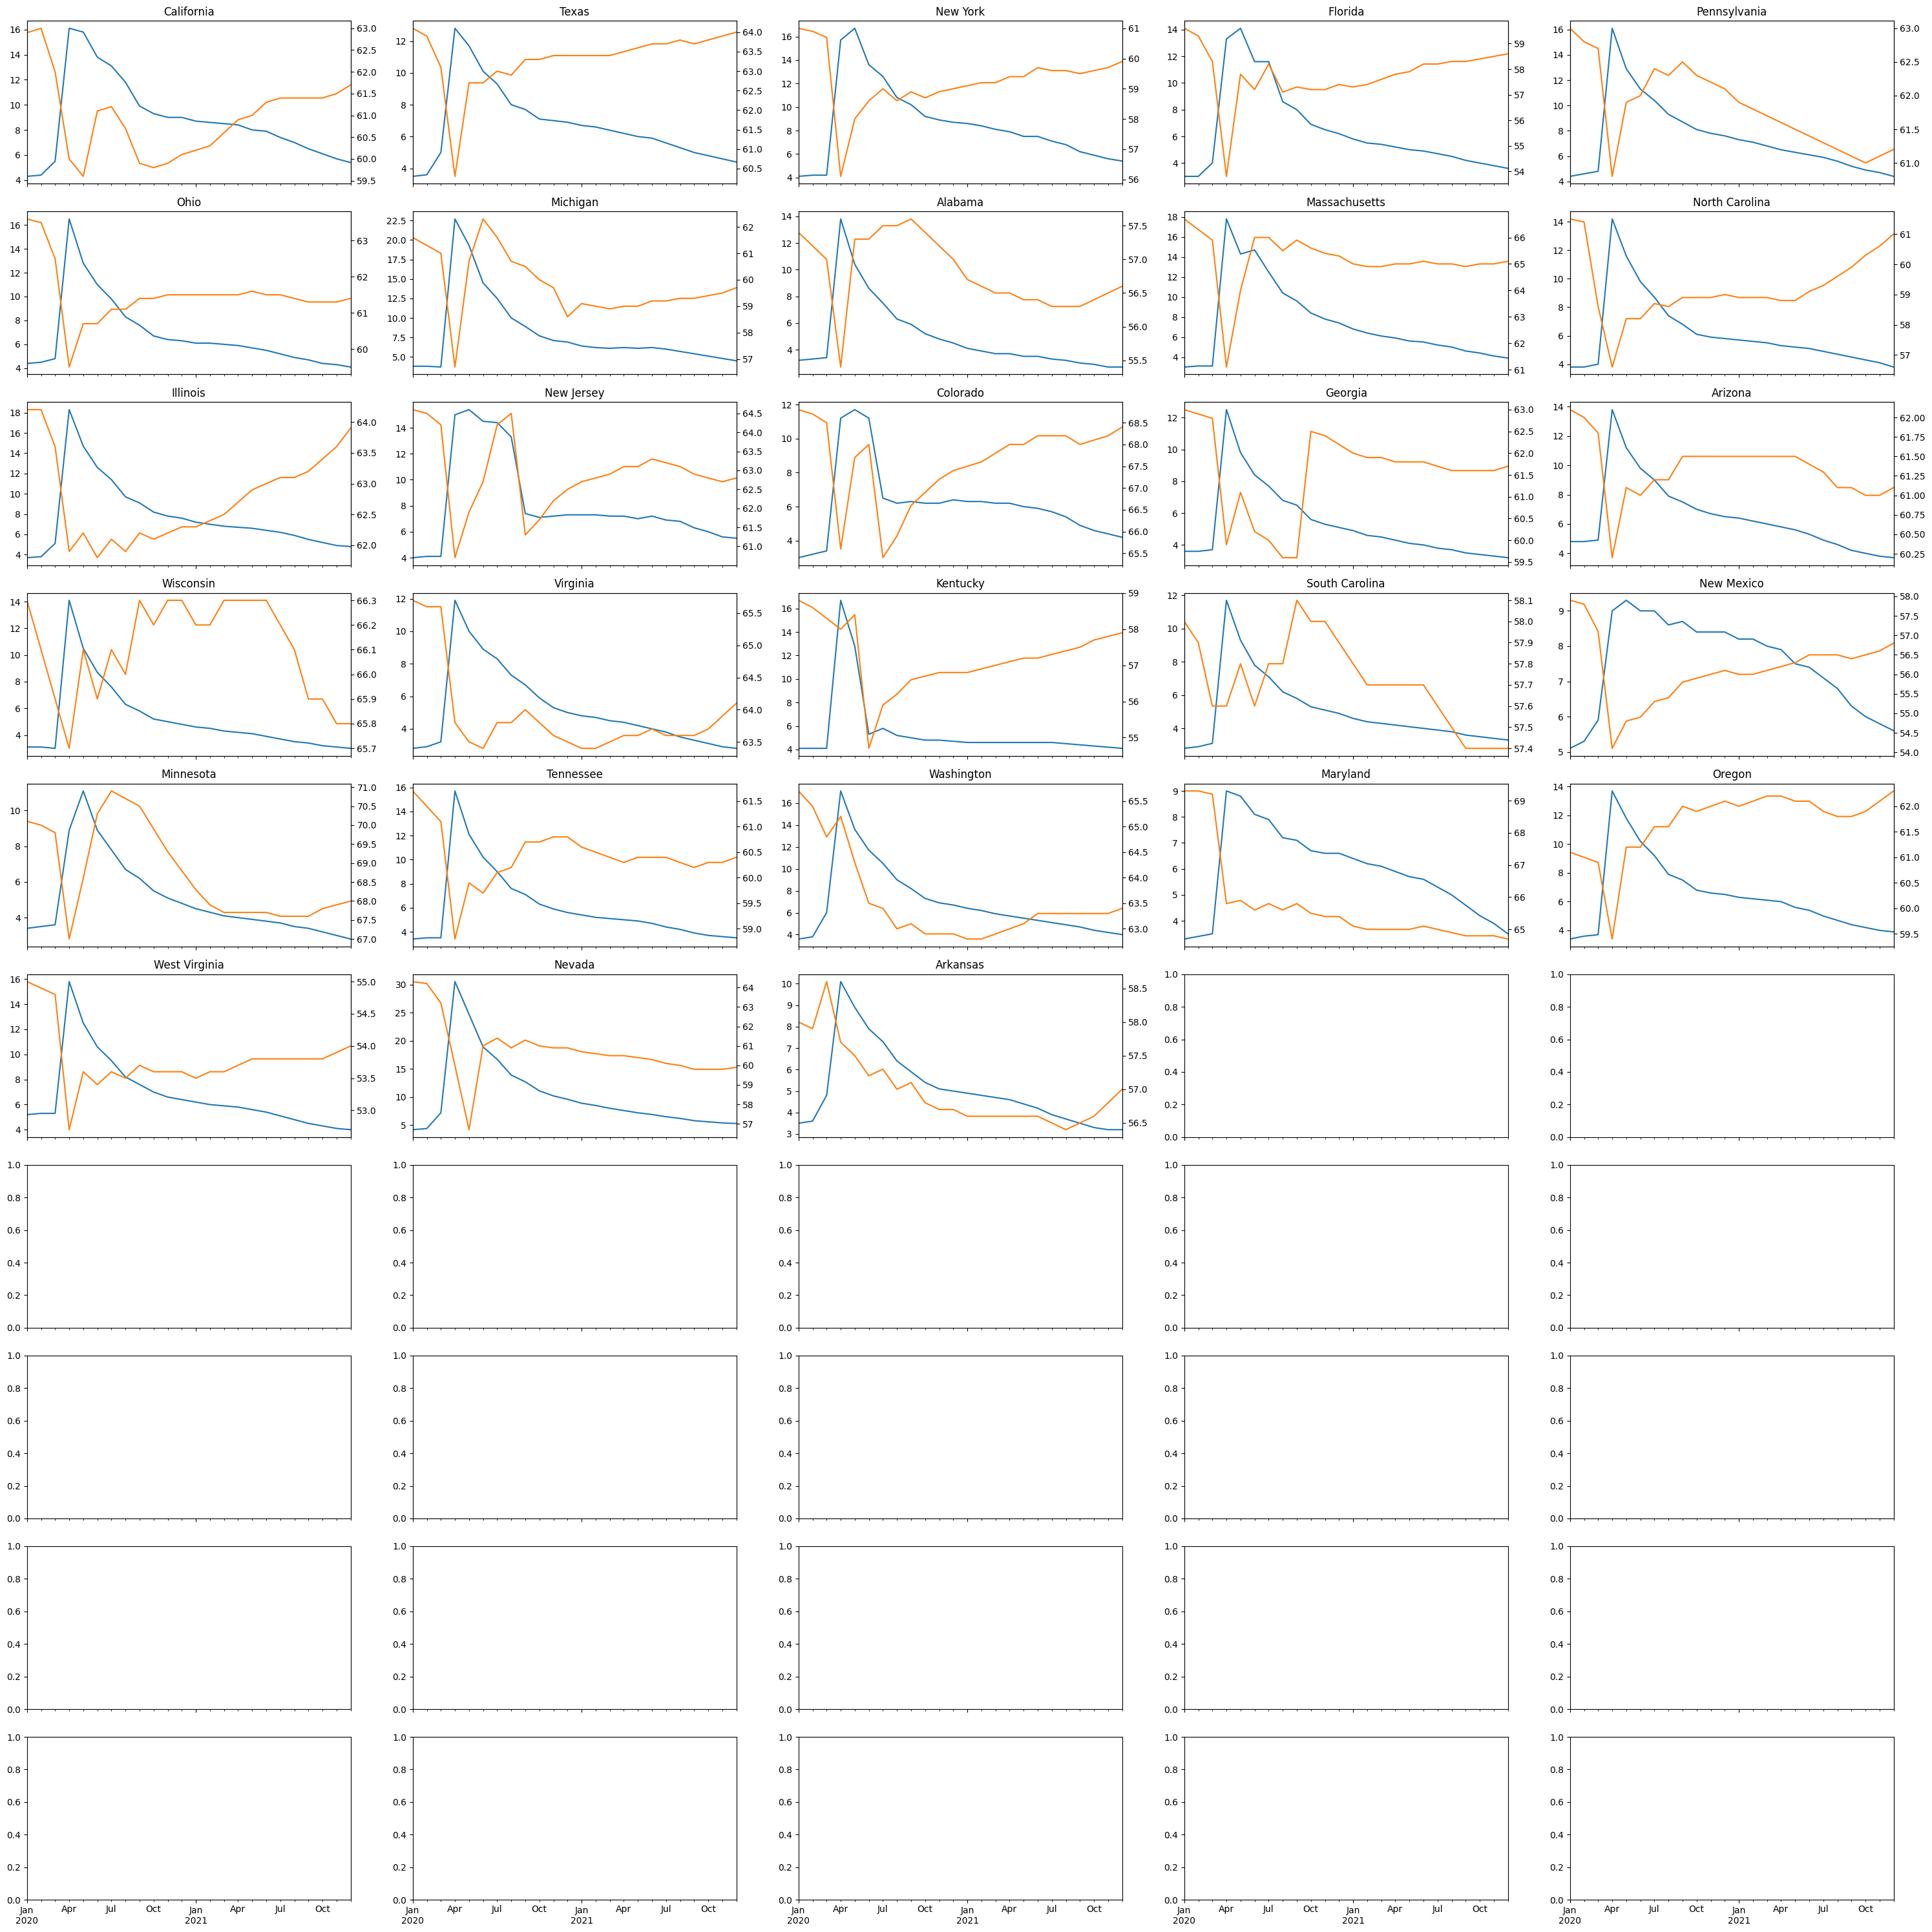

In [ ]:
import matplotlib.pyplot as plt

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    if state in ["District Of Columbia", "Puerto Rico"]:
        continue
    if state not in part_states.columns:
        continue  # skip if this state isn't in both datasets

    ax2 = axs[i].twinx()

    unemp_states.loc[mask_unemp, state].plot(ax=axs[i], label='Unemployment', color=color_pal[0])
    part_states.loc[mask_part, state].plot(ax=ax2, label='Participation', color=color_pal[1])

    axs[i].set_title(state)
    ax2.grid(False)
    i += 1

plt.tight_layout()
plt.show()



#**California**

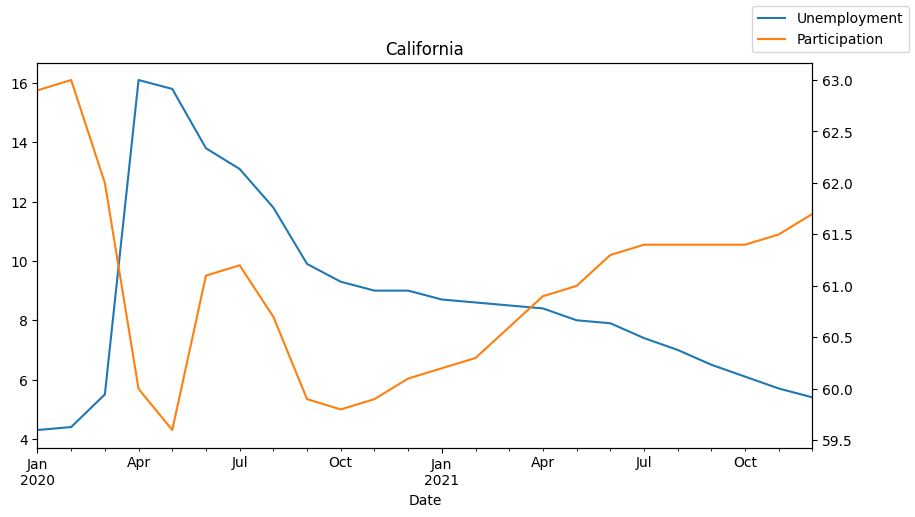

In [ ]:
unemp_states = unemp_states.rename(columns={"District Of Columbia": "Columbia"})

state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = unemp_states.asfreq('MS')
l1 = unemp_states.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()